In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2

C:\Users\lkkcp\anaconda3\envs\tf7\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lkkcp\anaconda3\envs\tf7\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lkkcp\anaconda3\envs\tf7\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lkkcp\anaconda3\envs\tf7\lib\site-packages\tensorflow\python\framework

In [5]:
import importlib
importlib.reload(readcsv1)
### forsome reason it doesn't autoreload the python files

<module 'readcsv1' from 'C:\\Users\\lkkcp\\Desktop\\NeuralNetwork\\ECE247-project-main\\readcsv1.py'>

In [6]:
## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
## get data, just Close values
#importlib.reload(readcsv1)
import readcsv1
fulldata = readcsv1.get_data(start = '1997-01-17',verbose=True,normalize=True).astype(np.float32)
print(fulldata.shape)

0 Data/000-EuroPerDollar(USDEUR).csv Close
1 Data/000-EuroPerDollar(USDEUR).csv Open
2 Data/000-EuroPerDollar(USDEUR).csv High
3 Data/000-EuroPerDollar(USDEUR).csv Low
4 Data/Bond-Germany2-yearNoteYield(IGDEU2D).csv Close
5 Data/Bond-Germany9-yearNoteYield(IGDEU9D).csv Close
6 Data/Bond-MoodyBAA(MOCBAAD).csv Close
7 Data/Bond-US10-yearBondYield(IGUSA10D).csv Close
8 Data/Bond-US2-yearNoteYield(IGUSA2D).csv Close
9 Data/Commod-GoldPrice(__XAU_D).csv Close
10 Data/Commod-GoldPrice(__XAU_D).csv Open
11 Data/Commod-GoldPrice(__XAU_D).csv High
12 Data/Commod-GoldPrice(__XAU_D).csv Low
13 Data/Commod-OilPrice(__WTC_D).csv Close
14 Data/Commod-OilPrice(__WTC_D).csv Open
15 Data/Commod-OilPrice(__WTC_D).csv High
16 Data/Commod-OilPrice(__WTC_D).csv Low
17 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Close
18 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Open
19 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv High
20 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Low
21 Data/Commod-ReutersCRBIndustrialRaw(CMCRBI

In [67]:
## indicators to use when training
biglist = [0,1,2,3,4,5,7,8,27,28,29,30,31,32,33,34,35,36,62,63,64,65,66,67,68,69,70,71,72,73,82,83,84,85,86]
smalllist =[0,1,2,3]
#data = fulldata[:,biglist]
data = fulldata[:,smalllist]
data.shape

(8750, 4)

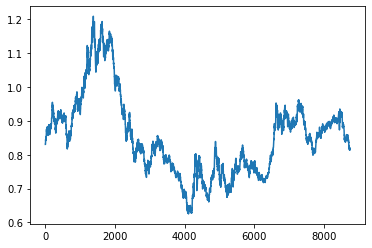

In [68]:
## visualize data
plt.plot(data[:, 0])
plt.show()

In [8]:
def generate_batches(data, label, batch_size, learn_window, predict_window, seed=None):
    """
    Randomly generate batches of windows, with replacement.
    
    - data: array, shape = (N, C)
    - label: the target to be predicted. Can be the closing price or slope of closing price etc.
    - batch_size: integer
    - learn_window: array of indices to learn from.
    - predict_window: array of indices to predict.
    - seed: seed for RNG, if any
    
    e.g. if learn_window = [0, 1, 2, ..., 9] and predict_window = [0, 1, 2, 3, 4],
    then learn on 10 days and try to predict next 5 days.
    
    returns: generator that yields random (X, y)
    - X_batch: shape = (B, len(learn_window), C)
    - y_batch: shape = (B, len(predict_window))
    """
    
    if seed != None:
        np.random.seed(seed)
        
    learn_window = np.array(learn_window)
    num_classes = np.array(predict_window)
    
    N, C = data.shape
    L, P = len(learn_window), len(predict_window)
    Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
    
    X = np.zeros((batch_size, L, C))
    y = np.zeros((batch_size, P))
    
    i = 0 # tracks index
    k = 0 # tracks batch size
    M = N - Lcap - Pcap # ceiling for i
    while True:
        
        if k == batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+learn_window,:]
        y[k] = label[i+Lcap+predict_window] 
        
        k += 1

        
## short test; should not throw error
G = generate_batches(data, data[:,0], 7, np.arange(50), np.arange(1))

X_batch, y_batch = next(G)
print(X_batch.shape)
print(y_batch.shape)

(7, 50, 4)
(7, 1)


# Now train to predict the closing prices of next X days using pure CNN

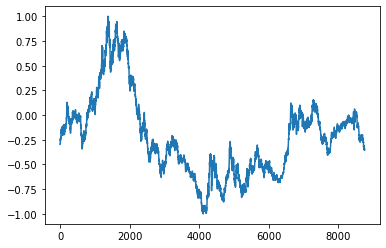

In [71]:
## ===== Preprocessing ==============================
## scale all data into interval [-1, 1]
data = fulldata[:,smalllist]

close_max = np.amax(data[:,0])
close_min = np.amin(data[:,0])
close_mid = (close_max + close_min)/2
scale = (close_max -close_min)/2

data = (data-close_mid)/scale
plt.plot(data[:,0])

In [72]:
## split into training, validation, and testing sets
data_train = data[:-1500, :]
data_val = data[-1500:-500, :]
data_test = data[-500:,:]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)
print("Validation:", data_val.shape)

Training: (7250, 4)
Testing: (500, 4)
Validation: (1000, 4)


In [73]:
## ===== model hyperparameters ======================
learn_window = np.arange(40)    ## learn from past 40 days, which is two months. 
predict_window = np.arange(10)   ## predict next 5 days

batch_size = 50
initial_learning_rate = 3e-4   
decay_steps = 300
decay_rate = 0.9
L1reg = 0.001
L2reg = 0.001
drop_prob = 0.2

## ==================================================

_, C = data_train.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)


model_1d = models.Sequential()
model_1d.add(layers.Conv1D(32, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 38 timesteps
model_1d.add(layers.Conv1D(64, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 36 timesteps
model_1d.add(layers.AveragePooling1D(pool_size=2,strides=2))
#18 timesteps
model_1d.add(layers.Conv1D(128, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
#16 timesteps
model_1d.add(layers.AveragePooling1D(pool_size=2,strides=2))
#8 timesteps
model_1d.add(layers.Reshape((1024,)))
model_1d.add(layers.Dense(100,activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
model_1d.add(layers.Dense(P) )
model_1d.compile(optimizer=opt, loss='mse')
model_1d.summary()

## Add dropout?
## Add regularization? 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 38, 32)            416       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 36, 64)            6208      
_________________________________________________________________
average_pooling1d_16 (Averag (None, 18, 64)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 16, 128)           24704     
_________________________________________________________________
average_pooling1d_17 (Averag (None, 8, 128)            0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)             

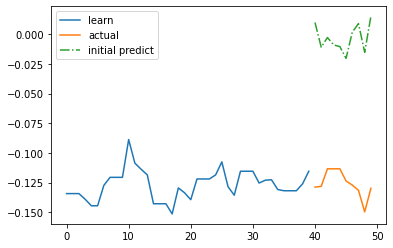

In [74]:
## generate validation data
G = generate_batches(data_val, data_val[:,0], 200, learn_window, predict_window)
X_val_batch, y_val_batch = next(G)

#### Before training, let's see what the model would predict for one sample in the val data
init_pred = model_1d.predict(X_val_batch[0:1,:,:])
Lcap = np.max(learn_window)+1
plt.plot(learn_window, X_val_batch[0, :, 0], label='learn')
plt.plot(Lcap+predict_window, y_val_batch[0], label='actual')
plt.plot(Lcap+predict_window, init_pred[0], '-.', label='initial predict')
plt.legend()
plt.show()

In [75]:
## train
G = generate_batches(data_train, data_train[:,0], batch_size, learn_window, predict_window)

model_1d.fit(G, steps_per_epoch=300, epochs=40, validation_data=(X_val_batch, y_val_batch))

Epoch 1/40
300/300 [==============================] - 6s 19ms/step - loss: 0.1637 - val_loss: 0.0703
Epoch 2/40
300/300 [==============================] - 5s 17ms/step - loss: 0.0493 - val_loss: 0.0314
Epoch 3/40
300/300 [==============================] - 5s 15ms/step - loss: 0.0278 - val_loss: 0.0184
Epoch 4/40
300/300 [==============================] - 4s 15ms/step - loss: 0.0180 - val_loss: 0.0129
Epoch 5/40
300/300 [==============================] - 5s 15ms/step - loss: 0.0154 - val_loss: 0.0101
Epoch 6/40
300/300 [==============================] - 5s 16ms/step - loss: 0.0143 - val_loss: 0.0085
Epoch 7/40
300/300 [==============================] - 5s 16ms/step - loss: 0.0110 - val_loss: 0.0076
Epoch 8/40
300/300 [==============================] - 4s 14ms/step - loss: 0.0094 - val_loss: 0.0068
Epoch 9/40
300/300 [==============================] - 5s 16ms/step - loss: 0.0092 - val_loss: 0.0063
Epoch 10/40
300/300 [==============================] - 5s 16ms/step - loss: 0.0082 - val_lo

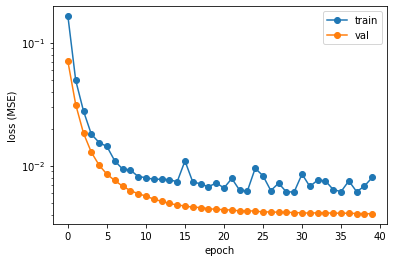

In [76]:
train_loss = model_1d.history.history['loss']
val_loss = model_1d.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [77]:
N, C = data_test.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap # ceiling for i

In [86]:
## test on all testing data

detail_window = np.arange(Pcap)

X_learn = np.zeros((M, L, C))
y_detail = np.zeros((M, Pcap))
y_predict = np.zeros((M, P))

for i in range(M):
    X_learn[i] = data_val[i+learn_window]
    y_detail[i] = data_val[i+Lcap+detail_window, 0]

y_predict = model_1d.predict(X_learn)

stream = np.zeros(M)
for i in range(M):
    mse = np.mean(np.square(y_detail[i, predict_window] - y_predict[i]))
#    scale_factor = 1/(scale)   ## bring back to original scale

    mse *= (scale**2)
    
    stream[i] = mse
    
print("Average MSE: %.5e" % np.mean(stream))

Average MSE: 9.74268e-05


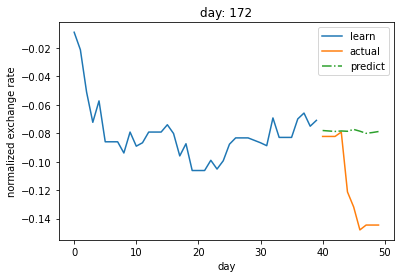

MSE: 1.909e-04


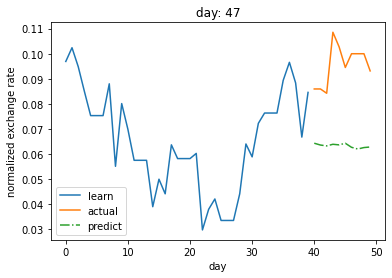

MSE: 9.367e-05


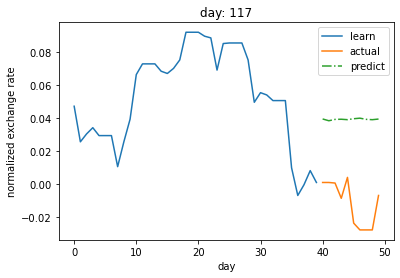

MSE: 2.354e-04


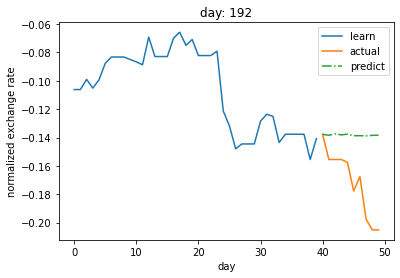

MSE: 1.367e-04


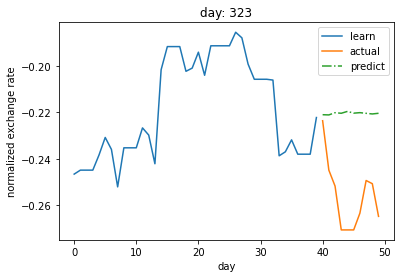

MSE: 1.257e-04


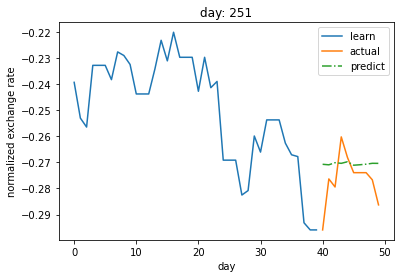

MSE: 9.998e-06


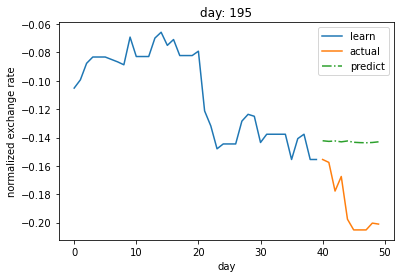

MSE: 1.984e-04


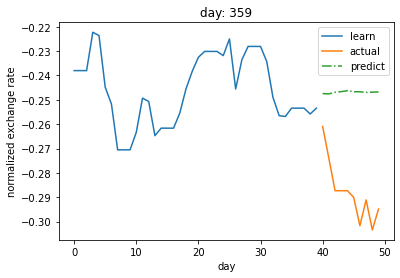

MSE: 1.554e-04


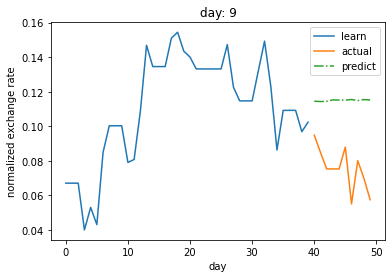

MSE: 1.448e-04


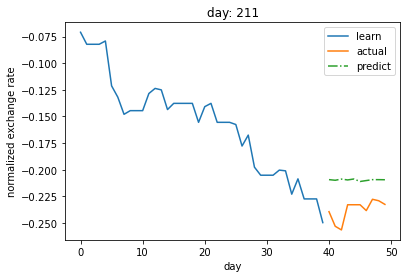

MSE: 7.433e-05


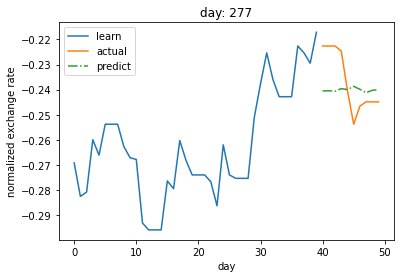

MSE: 1.295e-05


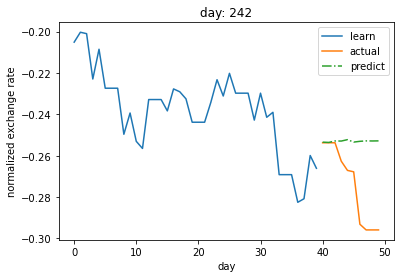

MSE: 6.550e-05


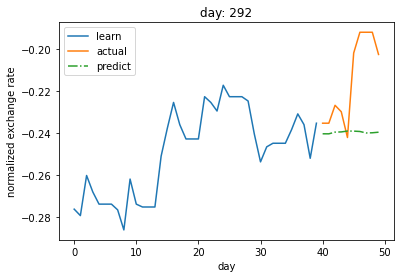

MSE: 8.508e-05


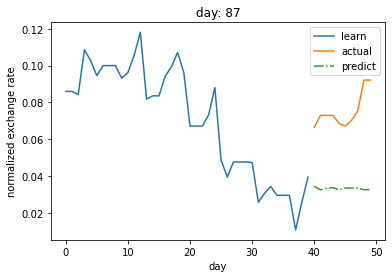

MSE: 1.572e-04


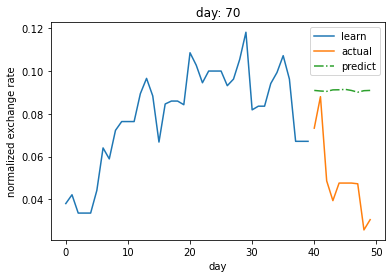

MSE: 1.721e-04


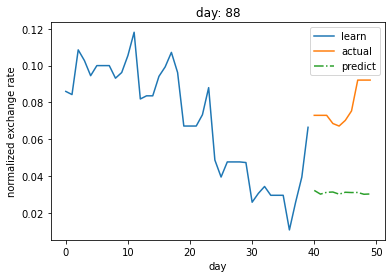

MSE: 1.957e-04


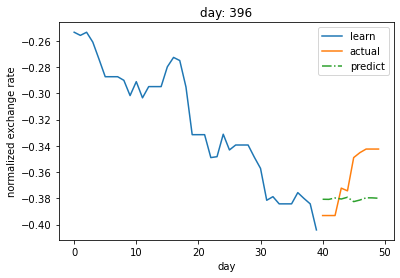

MSE: 6.125e-05


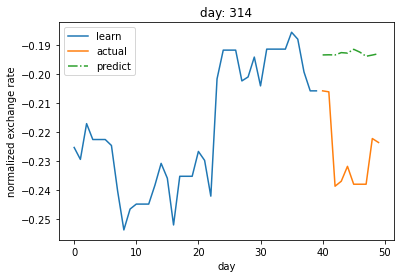

MSE: 1.177e-04


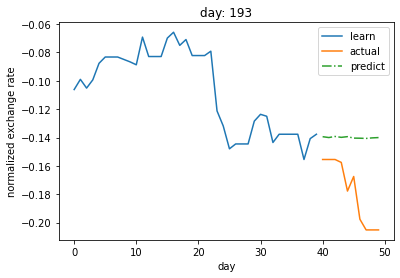

MSE: 1.633e-04


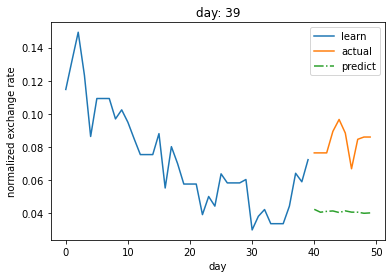

MSE: 1.557e-04


In [87]:
np.random.seed(0)
for i in np.random.randint(0, M, size=20):
    
    plt.plot(learn_window, X_learn[i, :, 0], label='learn')
    plt.plot(Lcap+detail_window, y_detail[i], label='actual')
    plt.plot(Lcap+predict_window, y_predict[i], '-.', label='predict')
    plt.title('day: %d' % i)
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()

    mse = np.mean(np.square(y_detail[i, predict_window] - y_predict[i]))
#    scale_factor = 1/scale   ## bring back to original scale
    mse *= (scale**2)
    
    print("MSE: %.3e" % mse)